# Lecture 8 - Full-Waveform Inversion (FWI)

To complete the trilogy of FWI lectures, we will use what we have learned in the previous sessions to implement an FWI problem in Devtio and highlight the core ideas behind the implementation of seismic inversion problems (where we create an image of the subsurface from field recorded data) in general.

<tr>
    <td> <img src="../lecture6/figures/survey-ship-diagram.png" alt="Drawing" style="width: 450px;"/> </td>
    <td> <img src="../lecture6/figures/Marmousi3D.png" alt="Drawing" style="width: 450px;"/> </td>
</tr>

**Left:** Sketch of offshore seismic survey. **Right:** Example model result for $v_p$.

## Inversion requirements

To recap, seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

And then the algorithm proceeds as follows:
1. start from a model $\mathbf{m}_0$,
2. evaluate the gradient of the objective function, $\nabla_{\mathbf{m}}\phi$, for the current model,
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model to obtain a new model,
5. iterate from step 2 using the new model until the objective function is sufficiently small (or we run out of patience).

That is, we need to implement the model update scheme

\begin{equation}
 \mathbf{m}_{n+1}=\mathbf{m}_n-\alpha\nabla_{\mathbf{m}}\phi.
\end{equation}


## Notes on the operators

As we have already described the creation of a forward modelling operator, we will only call a wrapper function here. This wrapper already contains all the necessary operators for seismic modeling, imaging and inversion. Operators introduced for the first time in this tutorial will be properly described.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output

## Computational considerations

As we will see, FWI is computationally extremely demanding. To keep this tutorial as lightweight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [2]:
nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

# True and initial (smooth) velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain.

Here, we are defining a "true" model - in practice this would be unknown.

Further, in practice, the "true" data will come from collecting and then pre-processing field data. Here, we will generate the "true" data using our "true" model. (This will help us understand the various components in the FWI algorithm and also help us verify our result!).

The "true" model will be used to generate our synthetic shot data and we will use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

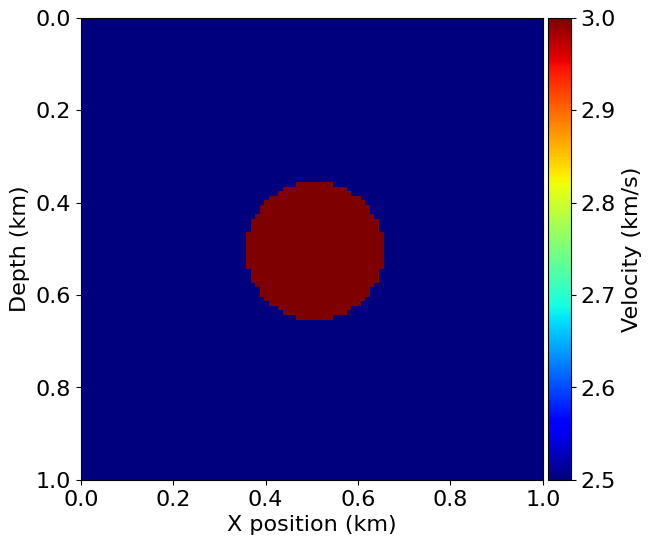

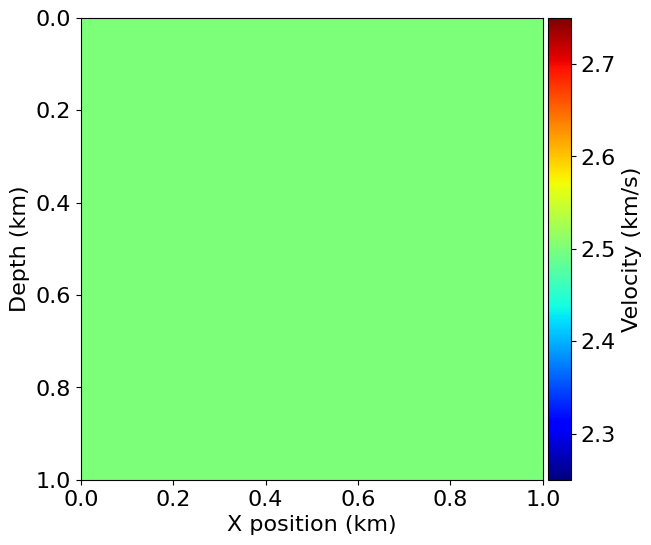

In [3]:
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model) # This is the "true" model - i.e. what the 'real' system looks like
plot_velocity(model0) # This is our initial guess

## Acquisition geometry

We next need to choose the configuration of our sources (from which the wave-pulse will be generated) and receivers (the positions at which the wave-field will be recorded).

We will start with the simplest case for inversion, namely a transmission experiment. The source(s) will be located on one side of the model and the receivers on the other side. This allows most of the information necessary for inversion to be recorded.

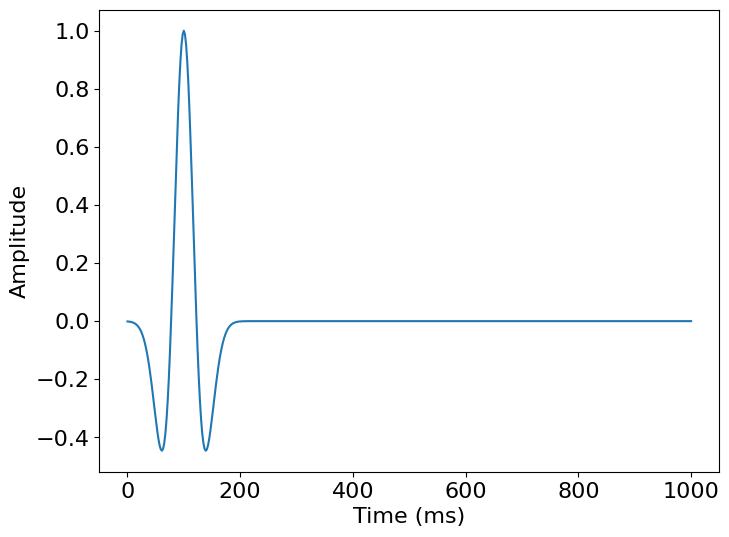

In [4]:
# Define acquisition geometry: 

from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. # 1000ms
f0 = 0.010 # 10Hz (=0.01 kHz)

# Note, distances below correspond to meters.
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Create the Geometry
# Along with storing the source and receiver locations defined above this will work out the points in time at
# at which we'll need the source signal and compute them according to the definiction of the Ricker-wavelet
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

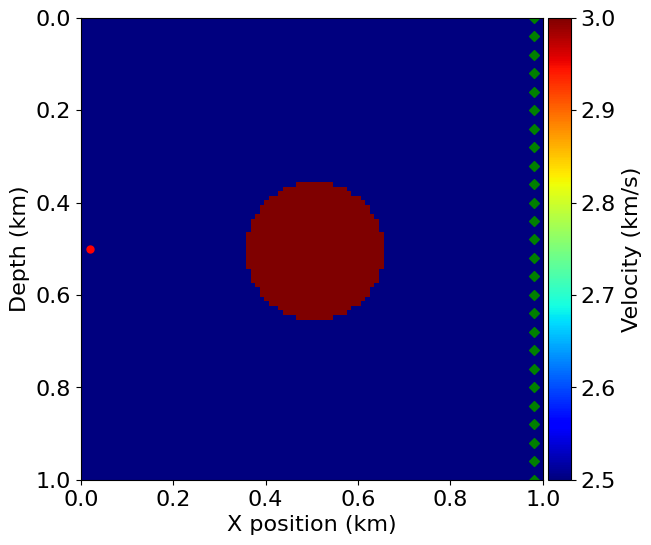

In [5]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

# Full-Waveform Inversion

As we noted previously, our inversion frame work will be based on solving the following boundary value problem for the second order acoustic wave-equation:

\begin{align*}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\nabla^2 u = s, \\
  u(\mathbf{x},0)=0, \\
  \frac{\partial u}{\partial t}(\mathbf{x},0)=0.
\label{eq:we0} \tag{1}
\end{align*}

We will use this PDE and the models above to generate our True (or field) data and our model (or smoothed) data.

## True and model data - and constructing the objective function

We can generate shot records (records in time of the wavefield at our receiver locations) for the true model and initial velocity model, since the difference between them will again form the basis of our imaging procedure.

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

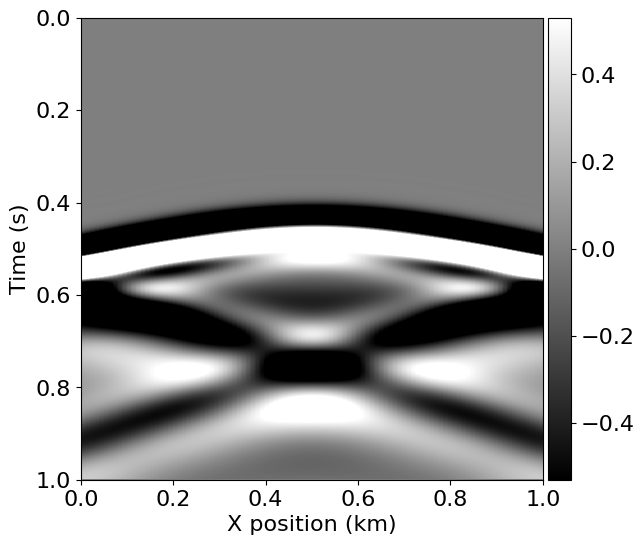

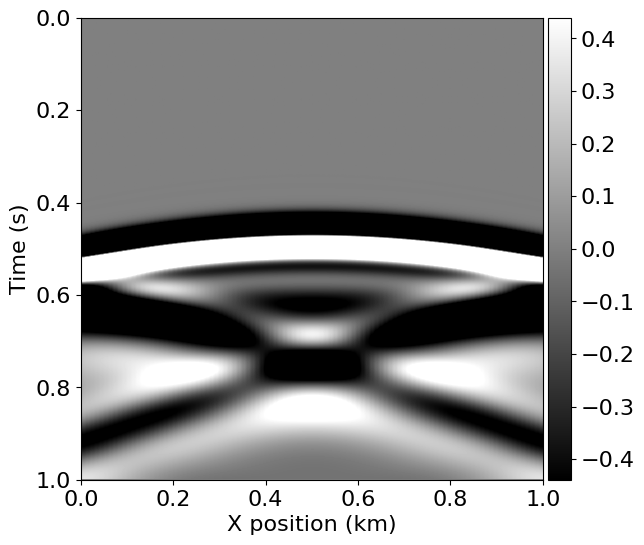

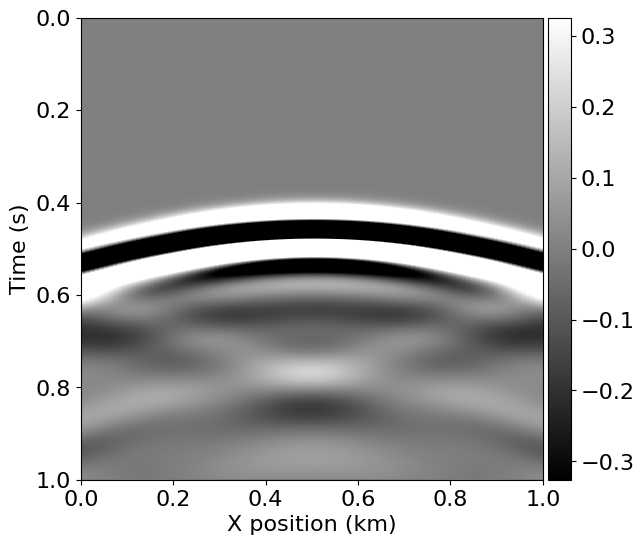

In [8]:
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn) # In reality, this would be our data from the experiment
plot_shotrecord(smooth_d.data, model, t0, tn) # This is our model data
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) # This is the data residual

To build a good estimation of the gradient we'll need to release pulses from several source locations. So lets pick some locations from which to fire our seismic pulses:

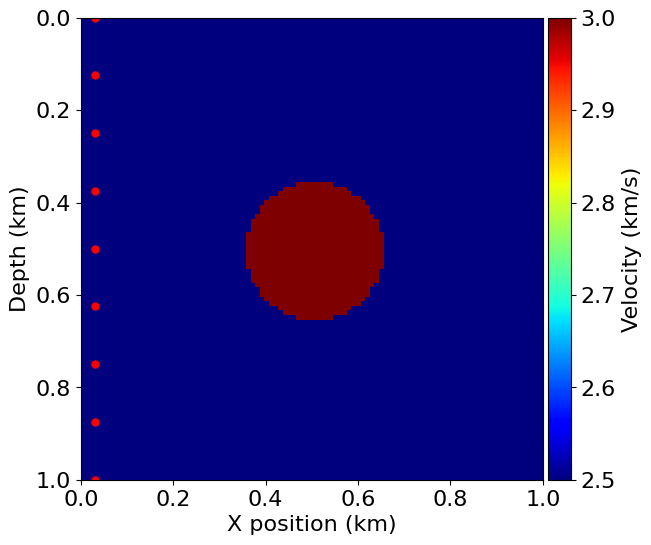

In [9]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

## Computing the objective function

Recall that the central purpose of FWI is to find a physical model of the wave-transmitting medium that
minimises the difference between an observed dataset and the same dataset as predicted by
the model. Consequently we need a means to measure this difference. There are many ways
to do this, but the most common is a *least-squares* formulation where we seek to minimise the
sum of the squares of the differences between the two datasets over all sources and receivers,
and over all times. That is, we seek to find a model that minimises the square of the $L_2-norm$
of the *data residuals*.

The $L_2-norm$ expresses the misfit between the two datasets as a single number. This number
is variously called the *cost function*, the *objective function*, the *misfit function*, or just the
*functional*. It is typically given the symbol $f$ or $\phi$ - we'll use $\phi$ below. It is a real positive scalar quantity, and it is
a function of the model $\mathbf{m}$ (that is, it depends on the velocity of pressure waves at each of the grid points in our computational domain). In practice, a factor of a half is often included in the definition
of the objective function to 'simplify' the formulation (as we will see later). Define:

\begin{equation}
  \phi(\mathbf{m})=\frac{1}{2}||\mathbf{p}-\mathbf{d}||^2=\frac{1}{2}||\delta\mathbf{d}||^2=\frac{1}{2}\delta\mathbf{d}^{T}\delta\mathbf{d}=\frac{1}{2}\sum_{n_s}\sum_{n_r}\sum_{n_t}|p-d|^2,
\label{eq:oe0} \tag{18}
\end{equation}

where $n_s$, $n_r$ and $n_t$ are the number of sources, receivers and time samples in the data set,
and $\mathbf{d}$ and $\mathbf{p}$ are the observed and predicted datasets.

The function below computes $\delta\mathbf{d}$ for each shot. We'll then sum and take the $L_2-norm$ of this as part of our gradient computation shortly.

In [10]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

## FWI gradient operator

We next need a function for computing the gradient of our objective function: $\nabla\phi(\mathbf{m})$.

To compute a single gradient $\nabla\phi(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

Recall from lecture 6, that the gradient computation can be formulated as

\begin{equation}
  \nabla_{\mathbf{m}}\phi=-\mathbf{u}^T\left(\frac{\partial \mathbf{A}}{\partial \mathbf{m}}\right)^T(\mathbf{A^{-1}})^T\mathbf{R}^T\delta\mathbf{d}.
\end{equation}

It is this quantity - `solver.gradient` - that the function below (`fwi_gradient`) is computing, along with the objective function - `objective`.

In [11]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

## Model updates

Having defined the functions to compute our objective function and gradient, let us look at the code and effect of applying a single update. That is, let us compute

\begin{equation}
 \mathbf{m}_{1}=\mathbf{m}_0-\alpha\nabla_{\mathbf{m}}\phi.
\end{equation}

(We will later create a function to apply this update repeatedly).

In [12]:
# Compute gradient of initial model
_, update = fwi_gradient(model0.vp)

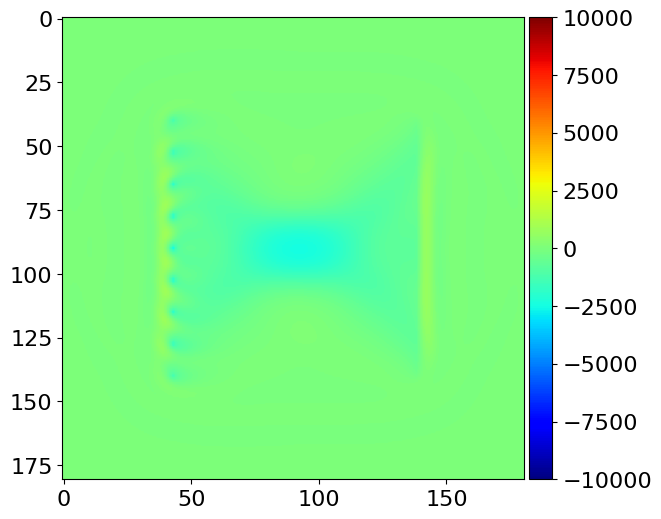

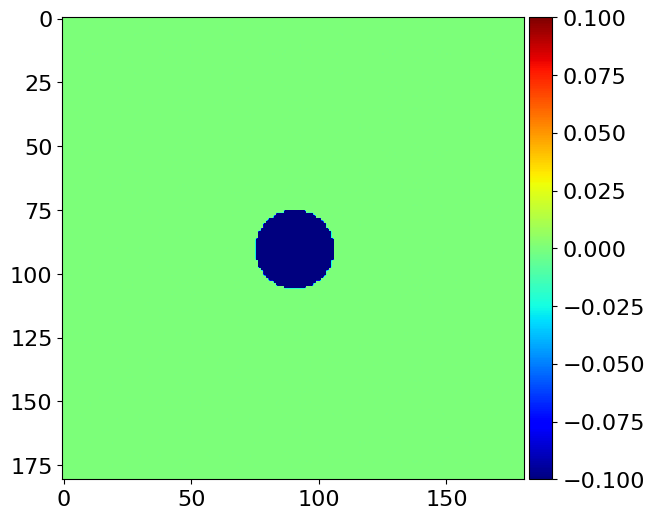

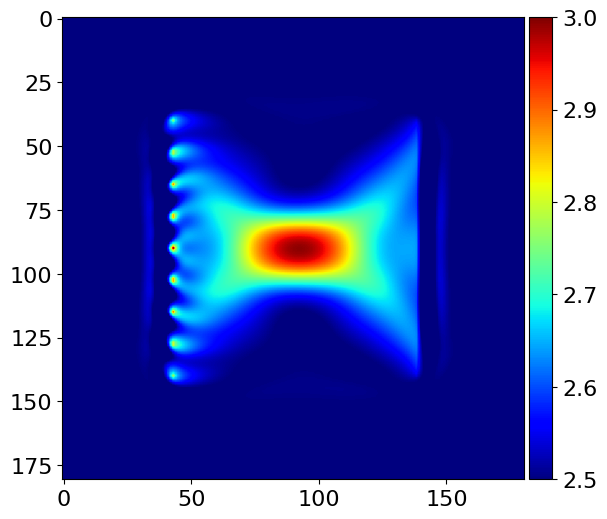

In [13]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

Ok - whilst there's more work to do, we can see a single update has taken us towards the true solution.

### Gradient Descent

Finally, we need write a function to *repeatedly* apply our update scheme:

\begin{equation}
 \mathbf{m}_{n+1}=\mathbf{m}_n-\alpha\nabla_{\mathbf{m}}\phi.
\end{equation}

In [14]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm # Note that dm = -grad(phi), hence the +
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [15]:
#NBVAL_SKIP

from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the objective function and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice we would use a move advanced method for computing alpha
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 39293.267055 at iteration 1
Objective value is 24506.893955 at iteration 2
Objective value is 14386.790018 at iteration 3
Objective value is 7907.686197 at iteration 4
Objective value is 3960.142918 at iteration 5


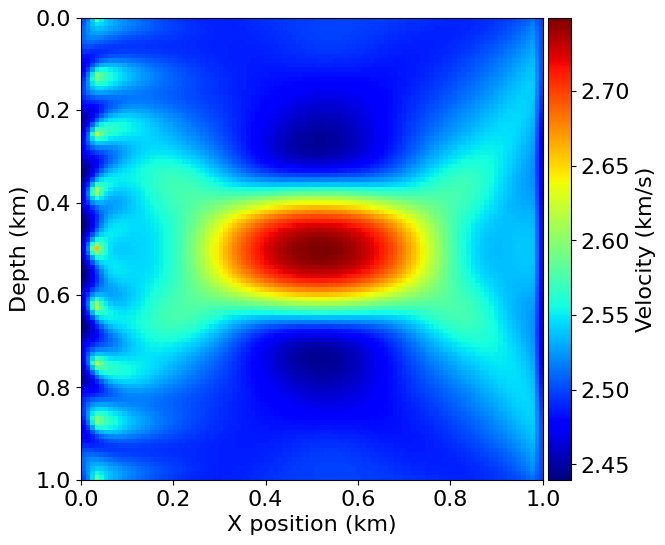

In [16]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)

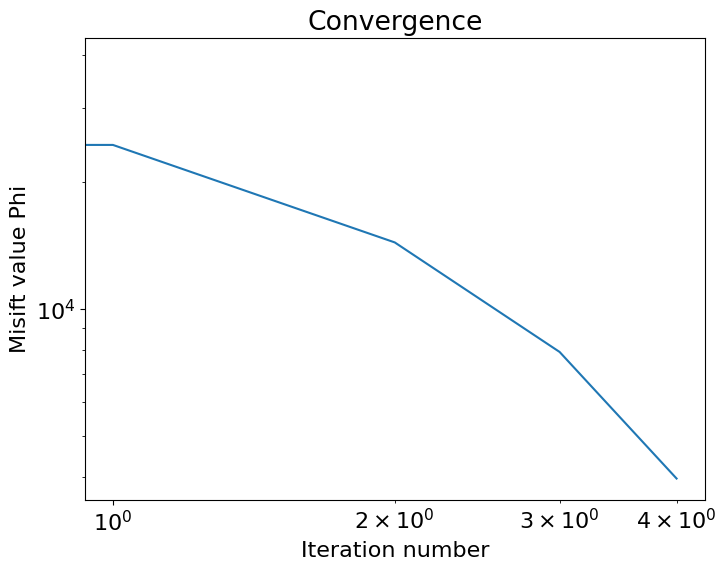

In [17]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._

## Coursework preparation

Read and play around with the above notebook. Once you're familiar with the various pieces comprising the FWI algorithm the coursework will be much more straightforward!